In [8]:
import scipy.io as sio
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps

import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import psd_array_welch
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
import pandas as pd
import seaborn as sns


from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline


In [3]:
mat_content = sio.loadmat('deap/s01.mat')
# print(mat_content['data'])
lables = mat_content['labels']
print(lables.shape)
# print(lables)
data=mat_content['data']
print(data.shape)



(40, 4)
(40, 40, 8064)


In [4]:
#read the 22 dataset and combine them into one
labels=[]
data=[]
for i in range(1,23):
    if(i<10):
        mat_content = sio.loadmat('deap/s0'+str(i)+'.mat')
        labels.append( mat_content['labels'])
        data.append( mat_content['data'])
    else:
        mat_content = sio.loadmat('deap/s'+str(i)+'.mat')
        labels.append( mat_content['labels'])
        data.append(mat_content['data'])

In [5]:
labels = np.array(labels)
print(labels.shape)   # (22, 40, 4) 22 subjects, 40 trials, 4 labels

(22, 40, 4)


In [6]:
data = np.array(data)
print(data.shape)   # (22, 40, 40, 8064) 22 subjects, 40 trials, 40 channels, 8064 samples

(22, 40, 40, 8064)


In [ ]:
data[0][0][0]

array([ 0.94823168,  1.65333533,  3.01372577, ..., -2.82648937,
       -4.47722969, -3.67692812])

In [ ]:
# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(880, 4)
print(labels.shape)
df_label_rating=pd.DataFrame(labels,columns=['valence','arousal','dominance','liking'])
print(df_label_rating.head())

data = np.array(data)
data = data.flatten()
data = data.reshape(880, 40, 8064) # 880 trials, 40 channels, 8064 samples
print(data.shape)



(880, 4)
   valence  arousal  dominance  liking
0     7.71     7.60       6.90    7.83
1     8.10     7.31       7.28    8.47
2     8.58     7.54       9.00    7.08
3     4.94     6.01       6.12    8.06
4     6.96     3.92       7.19    6.05
(880, 40, 8064)


<AxesSubplot: >

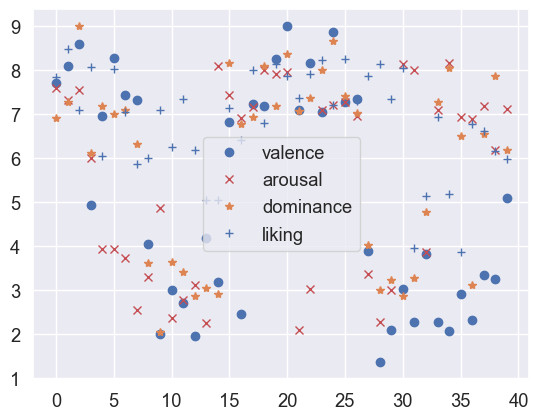

In [ ]:
# plot the first 40 data
df_label_rating.iloc[0:40].plot(style=['o','rx','*','b+'])

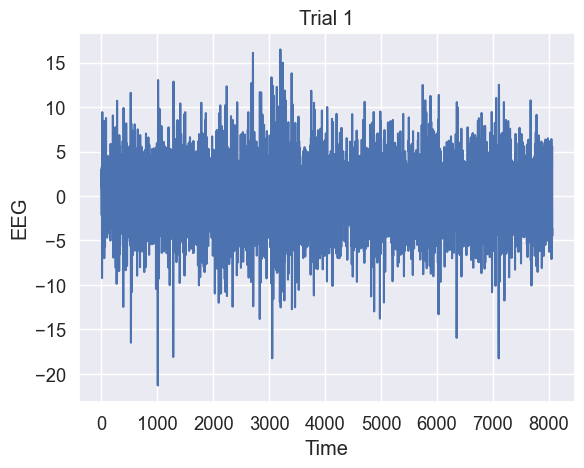

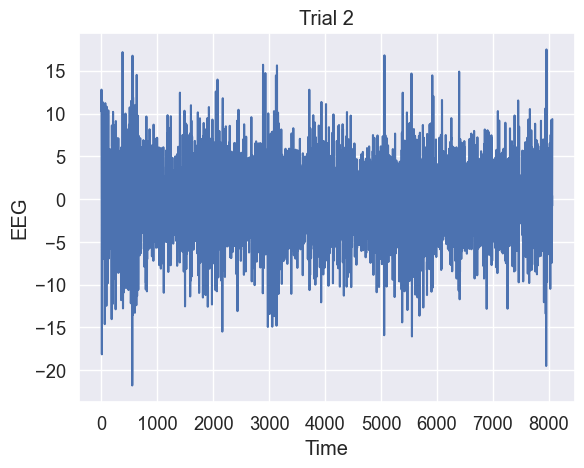

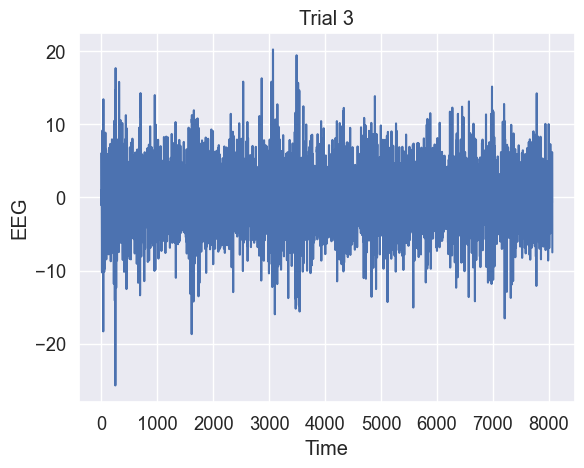

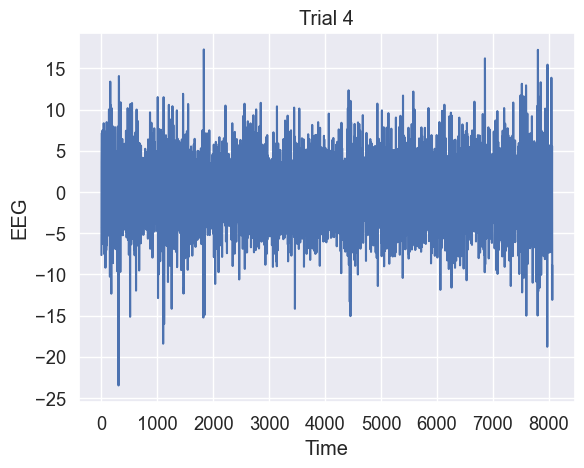

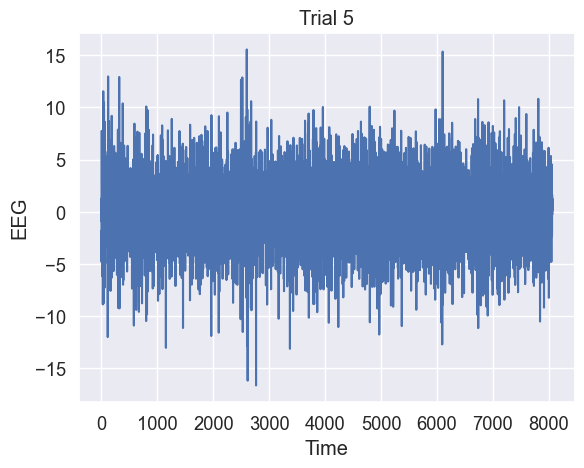

In [ ]:
# plot data for the first 5 trials
for i in range(5):
    plt.figure()
    plt.plot(data[i,0,:])
    plt.title('Trial '+str(i+1))
    plt.xlabel('Time')
    plt.ylabel('EEG')
    plt.show()

In [ ]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())



          Valence     Arousal
count  880.000000  880.000000
mean     5.218034    5.238898
std      2.093837    1.879631
min      1.000000    1.000000
25%      3.650000    3.895000
50%      5.040000    5.490000
75%      7.040000    6.795000
max      9.000000    9.000000


<AxesSubplot: >

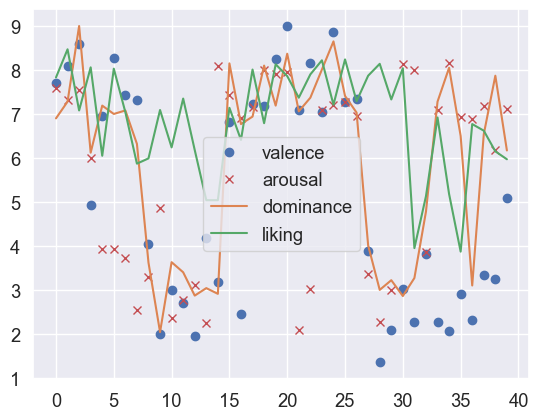

In [ ]:
# plot the first 40 data
df_label_rating.iloc[0:40].plot(style=['o','rx'])

## One hot encoding

In [ ]:

# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [ ]:
# Convert all ratings to boolean values
labels_encoded = []

for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])

labels_encoded = np.reshape(labels_encoded, (880, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())


       Positive Valence  High Arousal
count        880.000000    880.000000
mean           0.519318      0.502273
std            0.499911      0.500279
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      1.000000
75%            1.000000      1.000000
max            1.000000      1.000000


In [ ]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

In [ ]:
#Separate EEG and non-EEG data
# 32 vs 8
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
    
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


In [ ]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(880, 8, 8064)


In [ ]:
# Theta band, first trial

# data_3d=mat_content['data']
# # data.shape
# print(data_3d.shape)



# # eeg_data_2d=np.reshape(data_3d,(data_3d.shape[0],data_3d.shape[1]*data_3d.shape[2]))
# data_to_plot=data[0,0,:]
# eeg_data_2d=np.reshape(data_to_plot,(data_to_plot.shape[0],-1))
# print(eeg_data_2d.shape)
# # print(eeg_data_2d)
# # print(eeg_data_2d[0][0])

# n_channels = eeg_data_2d.shape[0]
# # print(n_channels)
# channel_names=['Ch{}'.format(i) for i in range(n_channels)]
# # print(channel_names)
# sfreq=250
# info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')
# # print(info)
# raw = mne.io.RawArray(eeg_data_2d, info)
# # print(raw)
# raw.save('stim_101.fif', overwrite=True)
# raw.plot_psd(fmax=50)
# raw.plot(duration=5, n_channels=10, scalings='auto')

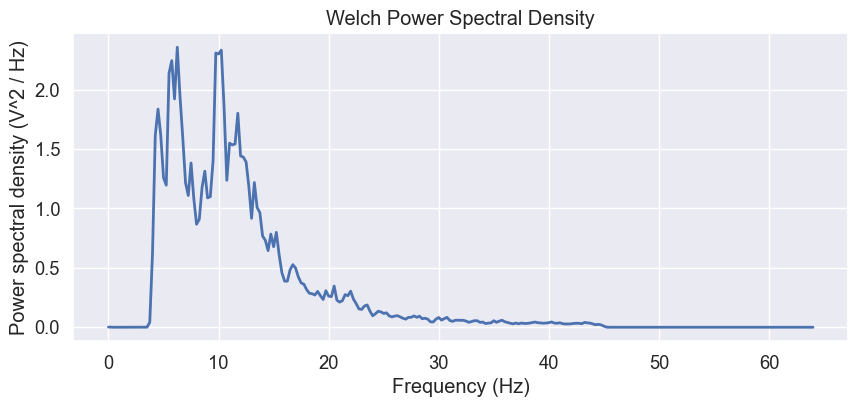

In [ ]:
# Welch's feature extraction
sns.set(font_scale=1.2)
# Define sampling frequency and time vector
sfreq = 128
time = np.arange(eeg_data.size) / sfreq
win = 4 * sfreq  # 4 seconds window for time-frequency decomposition
freqs, psd = signal.welch(eeg_data[0,31], sfreq, nperseg=win)

# Plot the power spectral density
plt.figure(figsize=(10, 4))
plt.plot(freqs, psd, lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.title('Welch Power Spectral Density')
plt.show()





In [ ]:
# Theta band power
# Define theta lower and upper limits
low, high = 4, 8
# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)



In [ ]:
#alpha band power
# Define alpha lower and upper limits
low, high = 8, 12
# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)


In [ ]:
#Beta band power
# Define beta lower and upper limits
low, high = 12, 30
# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)


In [ ]:
#Gamma band power
# Define gamma lower and upper limits
low, high = 30, 50
# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)


In [ ]:
#function to calculate band power
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band
    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg=(2/low)*sf
    # Compute the modified periodogram (Welch)
    freqs, psd = signal.welch(data, sf, nperseg=nperseg)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)
    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp


In [ ]:
def get_band_power(trial,channel,band):
    bd = (0,0)
    if band == 'theta':   # drownsiness, emotional connection, intuition, creativity
        bd = (4,8)
    elif band == 'alpha': # relaxation, meditation, calmness, focus, concentration
        bd = (8,12)
    elif band == 'beta':  # alertness, concentration, focus, memory, learning
        bd = (12,30)
    elif band == 'gamma': # cognition, perception, learning, multi-tasking
        bd = (30,50)
    return bandpower(eeg_data[trial,channel], 128, bd)



In [ ]:
print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295193
6.286556266834863
1.1062125930881577


In [ ]:
# info = mne.create_info(32, sfreq=128)
# print(info)
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)
raw_data = mne.io.RawArray(eeg_data[31], info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>
Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


In [ ]:
# mont1=mne.channels.make_dig_montage('biosemi32')
# mont1.plot()

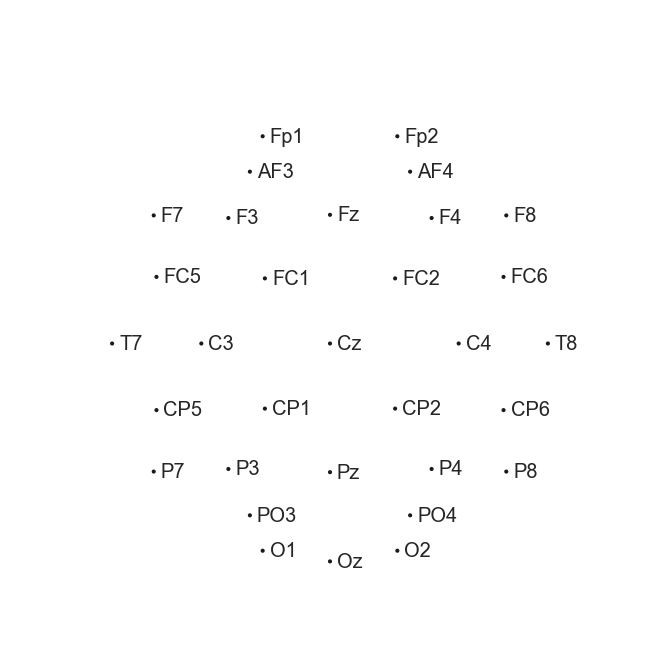

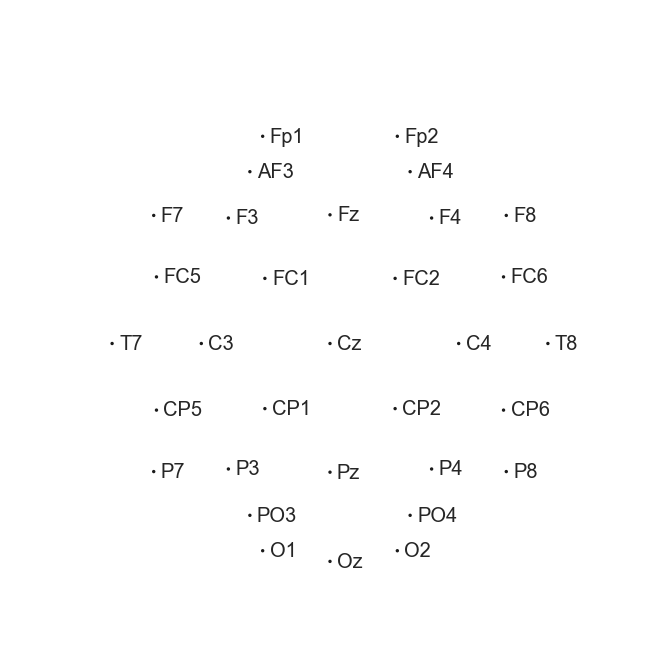

In [ ]:
#Plot sensor positions
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()
# montage = mne.channels.make_standard_montage('biosemi32', )
# channel_list = montage.get_positions()['ch_pos']
# mont1 = mne.channels.make_dig_montage(ch_pos=channel_list)
# mont1.plot()

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\Users\HXP\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


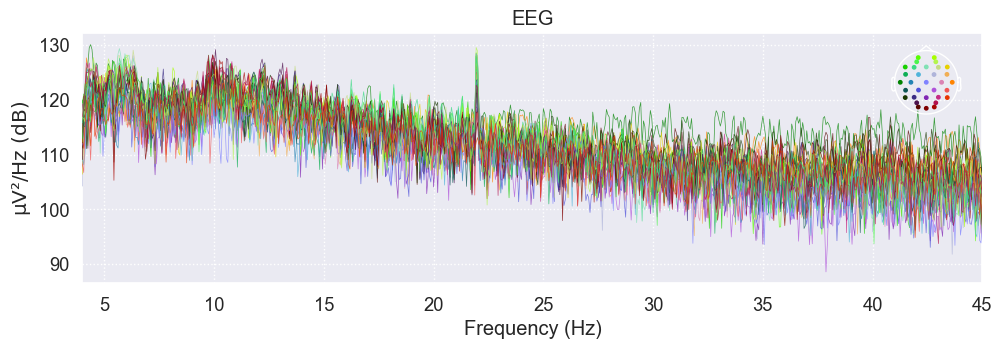

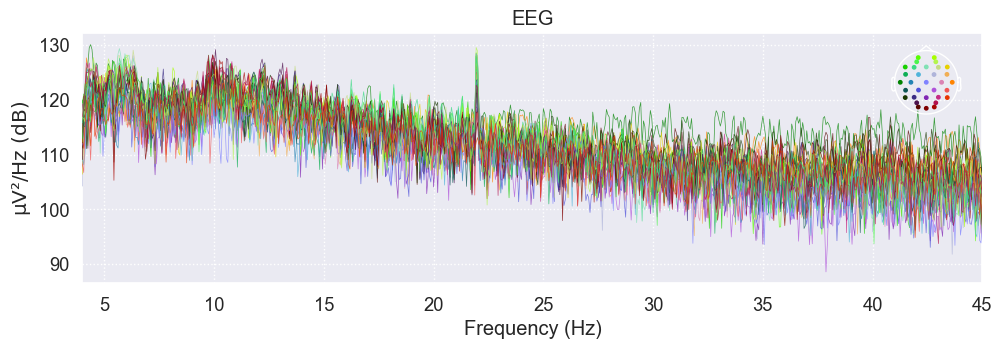

In [ ]:
# Plot the power spectral density across channels
mne.viz.plot_raw_psd(raw_data, fmin = 4, fmax= 45)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


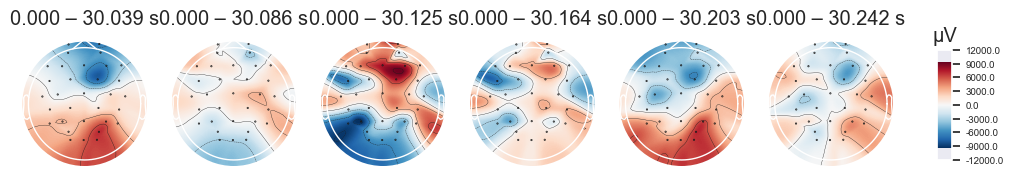

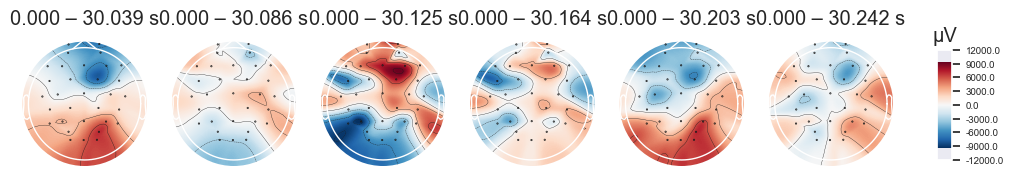

In [ ]:
# Theta band, first trial
evData_th = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_th.filter(4, 8) 

evData_th.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


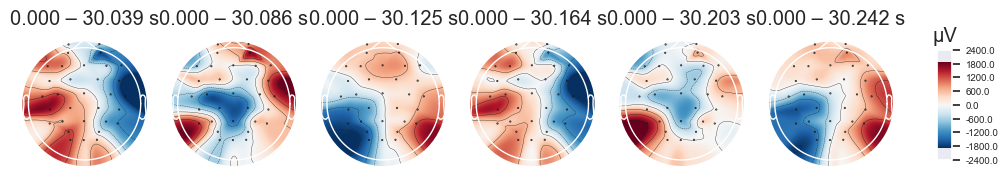

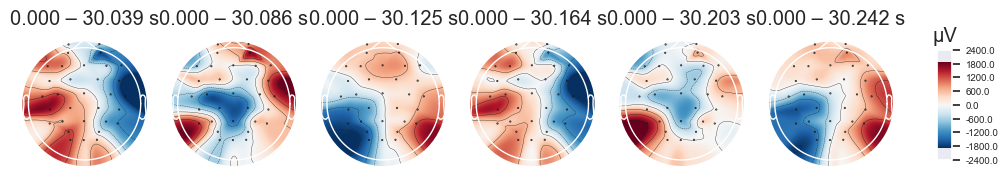

In [ ]:
# Alpha band, first trial
evData_al = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_al.filter(8, 12) 
evData_al.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


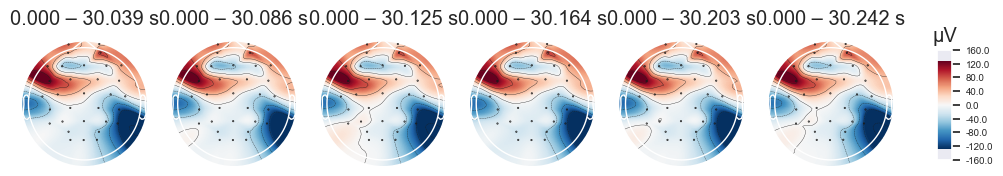

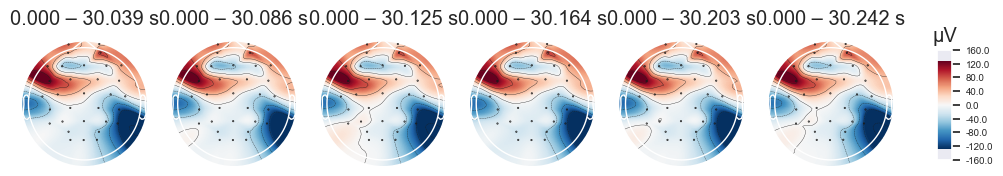

In [ ]:
# Beta band, first trial
evData_be = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_be.filter(12, 30)
evData_be.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')


Setting up band-pass filter from 30 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 57 samples (0.445 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


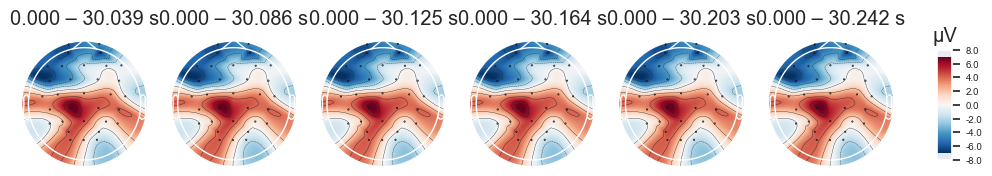

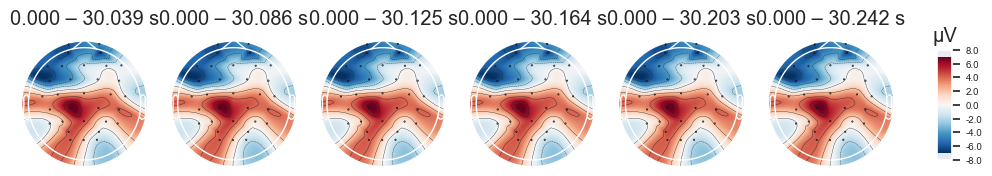

In [ ]:
# Gamma band, first trial
evData_ga = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_ga.filter(30, 50)
evData_ga.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')


In [ ]:
#Process new dataset with 6 EEG region and 4 bands power
eeg_band=[]
for i in range(len(eeg_data)):
    # eeg_band.append([])
    for j in range(len(eeg_data[0])):
        # eeg_band[i].append([])
        eeg_band.append(get_band_power(i,j,"theta"))
        eeg_band.append(get_band_power(i,j,"alpha"))
        eeg_band.append(get_band_power(i,j,"beta"))
        eeg_band.append(get_band_power(i,j,"gamma"))
# transform 880 x 32 x 8064 to 880 x 128
eeg_band = np.reshape(eeg_band, (880, 128))



In [ ]:
left=np.array(["Fp1","AF3","F7","T7"])
right=np.array(["Fp2","AF4","F8","FC6","T8"])
frontal=np.array(["F3","Fz","F4","FC1","FC2"])
central=np.array(["C3","Cz","C4","CP1","CP2","CP5","CP6"])
occipital=np.array(["O1","Oz","O2","PO3","PO4"])
parietal=np.array(["P3","Pz","P4","P7","P8"])


In [ ]:
# Dataframe for EEG band power
# Dataframe for Theta band power
eeg_band_theta=[]
for i in range(len(eeg_data)):
    # eeg_band_theta.append([])
    for j in range(len(eeg_data[0])):
        # eeg_band_theta[i].append([])
        eeg_band_theta.append(get_band_power(i,j,"theta"))

eeg_band_theta = np.reshape(eeg_band_theta, (880, 32))

df_theta = pd.DataFrame(data=eeg_band_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   5.476953e+02  1.275378e+03  9.614674e+02  2.081234e+03  9.465404e+02   
std    1.217591e+03  3.736183e+03  3.558846e+03  5.918704e+03  2.572976e+03   
min    8.143045e-12  6.944200e-12  1.005093e-11  1.188187e-11  8.050689e-12   
25%    2.409321e+01  1.860138e+01  2.204631e+01  3.912328e+01  1.387218e+01   
50%    5.845061e+01  7.275575e+01  7.399130e+01  1.053462e+02  4.300044e+01   
75%    3.662748e+02  3.134779e+02  1.963466e+02  2.787570e+02  2.560120e+02   
max    1.552414e+04  3.812287e+04  3.943132e+04  4.927279e+04  2.018267e+04   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   3.356567e+02  6.296859e+02  3.841774e+02  4.374696e+02  2.786744e+02   
std    7.140847e+02  1.774587e+03  6.900456e+02  1.

In [ ]:
# only print central region
print(df_theta[central].head(5))


             C3            Cz            C4           CP1           CP2  \
0  6.593216e-12  6.710365e-12  4.106544e-12  1.114598e-11  4.796927e-12   
1  4.530124e+00  2.518165e+00  3.853129e+00  2.101888e+00  2.048768e+00   
2  4.284358e+00  2.386166e+00  3.942938e+00  1.890259e+00  1.974655e+00   
3  4.171965e+00  7.414694e+00  3.498076e+00  1.883543e+00  1.736048e+00   
4  1.798486e+00  1.993286e+00  1.803010e+00  1.447578e+00  1.577524e+00   

            CP5           CP6  
0  6.234692e-12  5.441689e-12  
1  3.478843e+00  2.086140e+00  
2  3.711943e+00  2.503685e+00  
3  4.004765e+00  2.529543e+00  
4  1.857737e+00  1.496299e+00  


In [ ]:
# Dataframe for Alpha band power
eeg_band_alpha=[]
for i in range(len(eeg_data)):
    # eeg_band_alpha.append([])
    for j in range(len(eeg_data[0])):
        # eeg_band_alpha[i].append([])
        eeg_band_alpha.append(get_band_power(i,j,"alpha"))

eeg_band_alpha = np.reshape(eeg_band_alpha, (880, 32))
df_alpha = pd.DataFrame(data=eeg_band_alpha, columns=eeg_channels)
print(df_alpha.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.827770e+02  4.330061e+02  3.417257e+02  7.873957e+02  3.147361e+02   
std    3.976110e+02  1.257594e+03  1.216974e+03  2.308045e+03  8.258100e+02   
min    7.749397e-11  6.293348e-11  1.063048e-10  1.111206e-10  8.943303e-11   
25%    1.419147e+01  1.160664e+01  1.198029e+01  2.027352e+01  1.002601e+01   
50%    3.325528e+01  3.057807e+01  3.480832e+01  4.343559e+01  1.869576e+01   
75%    1.431223e+02  1.132199e+02  7.668653e+01  9.853214e+01  8.089379e+01   
max    5.627907e+03  1.238070e+04  1.276472e+04  2.084307e+04  6.575781e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.212775e+02  2.177963e+02  1.345692e+02  1.526746e+02  9.739853e+01   
std    2.394994e+02  5.892192e+02  2.122944e+02  4.

In [ ]:
# print occipital region
print(df_alpha[occipital].head(5))


             O1            Oz            O2           PO3           PO4
0  5.981224e-11  3.561603e-11  4.673037e-11  9.351421e-11  6.471960e-11
1  5.771424e+00  5.657407e+00  6.850178e+00  6.976067e+00  7.715087e+00
2  6.263437e+00  5.958844e+00  8.209320e+00  7.656804e+00  9.179372e+00
3  5.632504e+00  5.341003e+00  6.541218e+00  6.627711e+00  6.922430e+00
4  4.457119e+00  4.057350e+00  5.195625e+00  5.767454e+00  5.225959e+00


In [ ]:
# Dataframe for Beta band power
eeg_band_beta=[]
for i in range(len(eeg_data)):
    # eeg_band_beta.append([])
    for j in range(len(eeg_data[0])):
        # eeg_band_beta[i].append([])
        eeg_band_beta.append(get_band_power(i,j,"beta"))

eeg_band_beta = np.reshape(eeg_band_beta, (880, 32))
df_beta = pd.DataFrame(data=eeg_band_beta, columns=eeg_channels)
print(df_beta.describe())


                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.016046e+02  2.639453e+02  2.355002e+02  4.653926e+02  1.797859e+02   
std    1.983379e+02  7.963947e+02  7.883697e+02  1.519023e+03  4.581520e+02   
min    6.424993e-09  9.251838e-09  1.054943e-08  7.588302e-09  9.367651e-09   
25%    1.808682e+01  1.198300e+01  1.072901e+01  2.209180e+01  1.120456e+01   
50%    3.472251e+01  2.512552e+01  3.628217e+01  3.828849e+01  2.447575e+01   
75%    8.583555e+01  1.269000e+02  6.071346e+01  6.669544e+01  5.144377e+01   
max    3.528485e+03  5.784160e+03  5.841476e+03  1.484870e+04  3.094688e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   7.906470e+01  1.223977e+02  8.834796e+01  1.005360e+02  5.611261e+01   
std    1.430090e+02  2.926299e+02  9.900414e+01  3.

In [ ]:
# print frontal region
print(df_beta[frontal].head(5))


             F3            Fz            F4           FC1           FC2
0  1.054943e-08  2.948489e-09  1.286862e-09  5.282264e-09  1.932648e-09
1  7.867709e+00  6.653116e+00  7.969135e+00  4.306246e+00  5.800412e+00
2  9.839357e+00  7.598063e+00  9.444911e+00  4.390210e+00  6.377253e+00
3  7.032711e+00  6.481246e+00  6.763315e+00  3.946574e+00  5.341841e+00
4  6.021147e+00  5.356596e+00  5.797735e+00  3.145262e+00  4.608033e+00


In [ ]:
# Dataframe for Gamma band power
eeg_band_gamma=[]
for i in range(len(eeg_data)):
    # eeg_band_gamma.append([])
    for j in range(len(eeg_data[0])):
        # eeg_band_gamma[i].append([])
        eeg_band_gamma.append(get_band_power(i,j,"gamma"))

eeg_band_gamma = np.reshape(eeg_band_gamma, (880, 32))
df_gamma = pd.DataFrame(data=eeg_band_gamma, columns=eeg_channels)
print(df_gamma.describe())


                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   5.360867e+01  1.731207e+02  1.610146e+02  1.426119e+02  1.031943e+02   
std    1.276570e+02  6.298252e+02  6.173663e+02  5.124856e+02  3.318354e+02   
min    7.855230e-08  9.620235e-08  1.779440e-07  1.498229e-07  1.250809e-07   
25%    8.102510e+00  4.874894e+00  4.395161e+00  9.821623e+00  4.607630e+00   
50%    1.799279e+01  1.238636e+01  1.393912e+01  1.615717e+01  1.149817e+01   
75%    4.080366e+01  6.457354e+01  3.195087e+01  3.503863e+01  3.663708e+01   
max    2.444609e+03  4.721132e+03  4.727748e+03  5.070653e+03  2.681043e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   4.653662e+01  6.220372e+01  4.455589e+01  6.655591e+01  2.751458e+01   
std    1.131714e+02  1.701438e+02  5.705639e+01  2.

In [ ]:
# print parietal region
print(df_gamma[parietal].head(5))


             P3            Pz            P4            P7            P8
0  1.993276e-08  4.097485e-08  8.881738e-08  1.603738e-08  7.750794e-08
1  1.409664e+00  6.666064e-01  1.662602e+00  1.659514e+00  1.374718e+00
2  1.512494e+00  6.997981e-01  1.836493e+00  2.238773e+00  1.568136e+00
3  1.190931e+00  6.201165e-01  1.446032e+00  1.371775e+00  8.358031e-01
4  1.110650e+00  6.020712e-01  1.337467e+00  1.581048e+00  1.400003e+00


In [ ]:
# Train test split and fearure scaling

def train_test_split_scale(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    return X_train, X_test, y_train, y_test





In [ ]:
def feature_scaling(train,test):
    sc = StandardScaler()
    train = sc.fit_transform(train)
    test = sc.transform(test)
    return train,test

In [ ]:
# pip install keras
# pip install tensorflow

# implement batch normalization
# !pip install tensorflow



In [ ]:
# !pip install keras  



In [ ]:

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization

In [ ]:

# define the model architecture

def batch_normalization_model(input_dim=128):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    return model

# compile the model
def b_normalization(X_train, y_train, X_test, y_test):

    model = batch_normalization_model(X_train.shape[1])


    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # X_train, X_test, y_train, y_test = train_test_split_scale(eeg_band, df_arousal)
    # fit the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    # print('Accuracy: %.2f' % (accuracy*100))
    # return accuracy and f1 score
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)
    f1 = f1_score(y_test, y_pred)
    conf_metric = confusion_matrix(y_test, y_pred)
    return accuracy, f1, conf_metric
    # return accuracy





In [ ]:
# Cross  validation and hyperparameter tuning
band_names = ["theta", "alpha", "beta", "gamma"]
channel_names=["frontal","central","parietal","occipital","left","right"]
label_names=["arousal","valence"]


In [ ]:
clasifier_mlp=MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(128, 64, 32,16), random_state=1)

In [ ]:
clasifier_svm=SVC(kernel='rbf',gamma='auto')


In [ ]:
clasifier_knn=KNeighborsClassifier(n_neighbors=5)

In [ ]:
models=[]
models.append(('MLP',clasifier_mlp))
# models.append(('SVM',clasifier_svm))
#models.append(('KNN',clasifier_knn))


In [ ]:
# Cross validation
def cross_validation(X,y,score):
    x_train,X_test,y_train,y_test=train_test_split_scale(X,y)
    x_train,X_test=feature_scaling(x_train,X_test)

    names=[]
    means=[]
    stds=[]
    for name,model in models:
        kfold=model_selection.KFold(n_splits=10,shuffle=True,random_state=1)
        cv_results=model_selection.cross_val_score(model,x_train,y_train,cv=kfold,scoring=score)
        names.append(name)
        means.append(cv_results.mean())
        stds.append(cv_results.std())
    return names,means,stds

    


In [ ]:
#Aousal prediction
cross_validation(eeg_band,df_arousal,'accuracy')


c:\Users\HXP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(['MLP'], [0.6036753040719196], [0.06595599291489007])

In [ ]:
cross_validation(eeg_band,df_arousal,'f1') 

c:\Users\HXP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(['MLP'], [0.6050640853239904], [0.06558115308690265])

In [ ]:
# valence prediction
cross_validation(eeg_band,df_valence,'accuracy')

c:\Users\HXP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(['MLP'], [0.6297726070861979], [0.045961914576120796])

In [ ]:
cross_validation(eeg_band,df_valence,'f1')

c:\Users\HXP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(['MLP'], [0.6127034375329632], [0.048156261742796])

In [ ]:
# function to run classification model
def run_model(band,channel,label,clf):
    if band=="theta":
        X=df_theta
    elif band=="alpha":
        X=df_alpha
    elif band=="beta":
        X=df_beta
    elif band=="gamma":
        X=df_gamma
    if channel=="frontal":
        X=X[frontal]
    elif channel=="central":
        X=X[central]
    elif channel=="parietal":
        X=X[parietal]
    elif channel=="occipital":
        X=X[occipital]
    elif channel=="left":
        X=X[left]
    elif channel=="right":
        X=X[right]
    if label=="arousal":
        y=df_arousal
    elif label=="valence":
        y=df_valence
    x_train,X_test,y_train,y_test=train_test_split_scale(X,y)
    x_train,X_test=feature_scaling(x_train,X_test)


    if clf=="MLP":
       clasifier_svm.fit(x_train,y_train)
       y_pred=clasifier_svm.predict(X_test)
    # elif clf=="SVM":
    #     clasifier_svm.fit(x_train,y_train)
    #     y_pred=clasifier_svm.predict(X_test)
    # elif clf=="KNN":
    #     clasifier_knn.fit(x_train,y_train)
    #     y_pred=clasifier_knn.predict(X_test)

    

    
    # print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # print("F1 score:",metrics.f1_score(y_test, y_pred,average='weighted'))
    # print("Precision:",metrics.precision_score(y_test, y_pred,average='weighted'))
    # print("Recall:",metrics.recall_score(y_test, y_pred,average='weighted'))
    # print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, y_pred))
    # print("Classification Report:\n",metrics.classification_report(y_test, y_pred))
    return y_test,y_pred



In [ ]:
df_theta.shape

(880, 32)

In [ ]:
def run_model_for_bn(band,channel,label,clf):
    if band=="theta":
        X=df_theta
    elif band=="alpha":
        X=df_alpha
    elif band=="beta":
        X=df_beta
    elif band=="gamma":
        X=df_gamma
    if channel=="frontal":
        X=X[frontal]
    elif channel=="central":
        X=X[central]
    elif channel=="parietal":
        X=X[parietal]
    elif channel=="occipital":
        X=X[occipital]
    elif channel=="left":
        X=X[left]
    elif channel=="right":
        X=X[right]
    if label=="arousal":
        y=df_arousal
    elif label=="valence":
        y=df_valence
    x_train,X_test,y_train,y_test=train_test_split_scale(X,y)
    x_train,X_test=feature_scaling(x_train,X_test)
    
    return b_normalization(x_train,y_train,X_test,y_test)

    

In [ ]:
print(eeg_band.shape)

(880, 128)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split_scale(eeg_band, df_arousal)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(616, 128) (264, 128) (616,) (264,)


In [ ]:
b_normalization(X_train, y_train, X_test, y_test)

9/9 [==============================] - 1s 3ms/step


(0.6136363744735718,
 0.6458333333333334,
 array([[69, 60],
        [42, 93]], dtype=int64))

In [ ]:
def print_accuracy_for_bn(label,clf):
    
    max_band_conf_metric=dict()
    band_acc=dict()
    # band_channel_f1=dict()
    for band in band_names:
        channel_per_band_acc=dict()
        max_band_conf_metric[band]=None
        max_band_acc=0
        max_band_f1=None
        max_band_channel=None
        for channel in channel_names:
            acc, f1, conf_metric = run_model_for_bn(band,channel,label,clf)
            if acc>max_band_acc:
                max_band_acc=acc
                max_band_f1=f1
                max_band_channel=channel
                max_band_conf_metric[band]=conf_metric
            channel_per_band_acc[channel]=acc

            print(f"Band: {band}, Channel: {channel}, Accuracy: {acc}, F1: {f1}")
            print("Confusion metric",conf_metric)
            
        band_acc[band]=channel_per_band_acc

    return max_band_conf_metric, band_acc
        
        



In [ ]:
import itertools

9/9 [==============================] - 0s 2ms/step
Band: theta, Channel: frontal, Accuracy: 0.5227272510528564, F1: 0.5153846153846154
Confusion metric [[71 58]
 [68 67]]
9/9 [==============================] - 0s 2ms/step
Band: theta, Channel: central, Accuracy: 0.5037878751754761, F1: 0.41777777777777775
Confusion metric [[86 43]
 [88 47]]
9/9 [==============================] - 0s 1ms/step
Band: theta, Channel: parietal, Accuracy: 0.5113636255264282, F1: 0.5019305019305019
Confusion metric [[70 59]
 [70 65]]
9/9 [==============================] - 0s 2ms/step
Band: theta, Channel: occipital, Accuracy: 0.5530303120613098, F1: 0.6358024691358025
Confusion metric [[ 43  86]
 [ 32 103]]
9/9 [==============================] - 0s 2ms/step
Band: theta, Channel: left, Accuracy: 0.5719696879386902, F1: 0.5767790262172284
Confusion metric [[74 55]
 [58 77]]
9/9 [==============================] - 0s 2ms/step
Band: theta, Channel: right, Accuracy: 0.6325757503509521, F1: 0.6572438162544171
Confusi

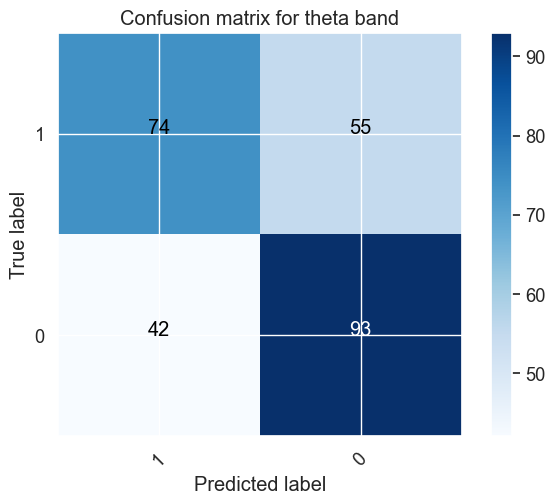

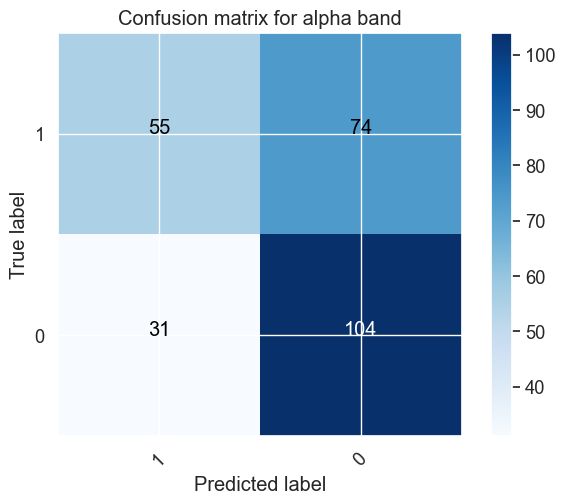

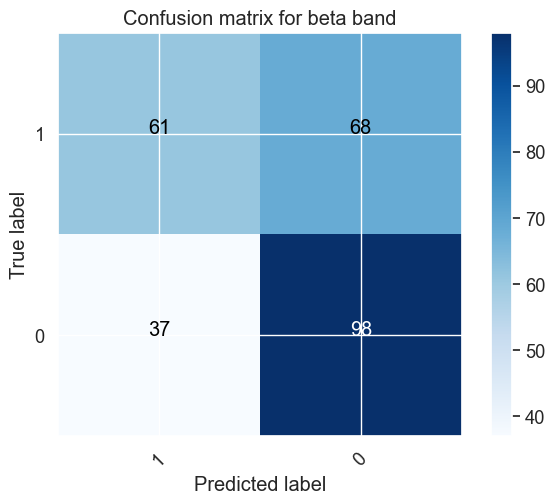

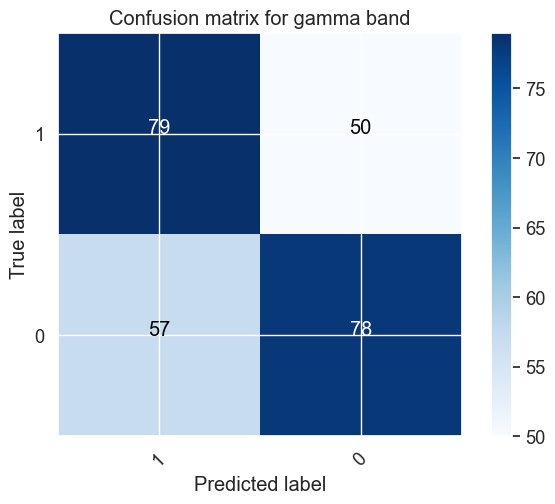

In [ ]:
confusion_metric, band_acc_a = print_accuracy_for_bn("arousal","BN")

for band in band_names:
# band = "theta"

    cm = confusion_metric[band]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    # plt.tight_layout()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.title(f"Confusion matrix for {band} band")
    # plt.show()

    classes = df_valence.unique().tolist()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"Confusion matrix for {band} band")
    plt.show()




9/9 [==============================] - 1s 3ms/step
Band: theta, Channel: frontal, Accuracy: 0.5530303120613098, F1: 0.5902777777777778
Confusion metric [[61 59]
 [59 85]]
9/9 [==============================] - 1s 4ms/step
Band: theta, Channel: central, Accuracy: 0.5340909361839294, F1: 0.5287356321839081
Confusion metric [[72 48]
 [75 69]]
9/9 [==============================] - 1s 4ms/step
Band: theta, Channel: parietal, Accuracy: 0.5303030014038086, F1: 0.5838926174496644
Confusion metric [[53 67]
 [57 87]]
9/9 [==============================] - 0s 3ms/step
Band: theta, Channel: occipital, Accuracy: 0.5340909361839294, F1: 0.5743944636678201
Confusion metric [[58 62]
 [61 83]]
9/9 [==============================] - 0s 4ms/step
Band: theta, Channel: left, Accuracy: 0.5568181872367859, F1: 0.6285714285714286
Confusion metric [[48 72]
 [45 99]]
9/9 [==============================] - 1s 3ms/step
Band: theta, Channel: right, Accuracy: 0.5378788113594055, F1: 0.5763888888888888
Confusion me

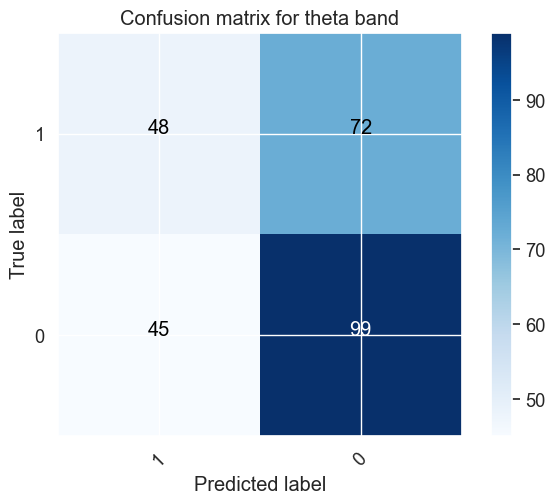

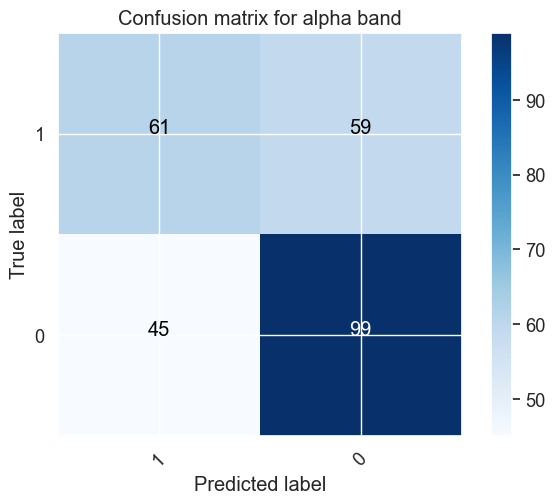

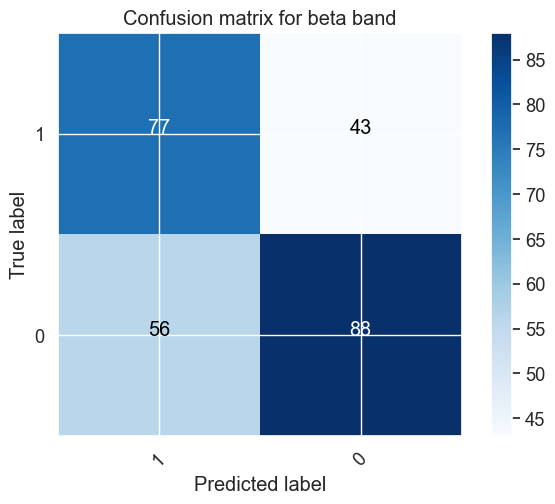

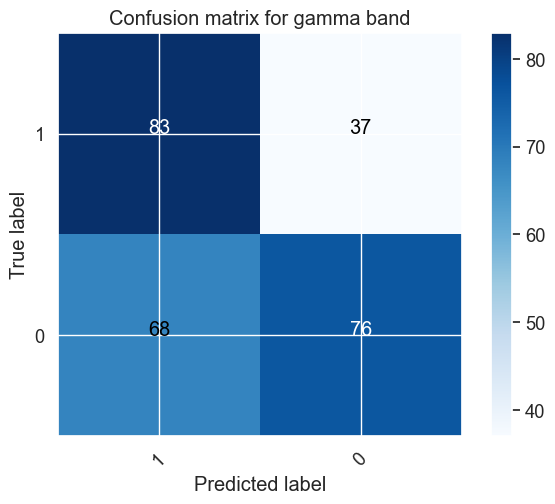

In [ ]:
confusion_metric, band_acc_v = print_accuracy_for_bn("valence","BN")

for band in band_names:
# band = "theta"

    cm = confusion_metric[band]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    # plt.tight_layout()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.title(f"Confusion matrix for {band} band")
    # plt.show()

    classes = df_valence.unique().tolist()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f"Confusion matrix for {band} band")
    plt.show()




In [ ]:
# convert band_acc_v to dataframe
df_band_acc_v = pd.DataFrame.from_dict(band_acc_v)
df_band_acc_v = df_band_acc_v.transpose()



# convert band_acc_a to dataframe
df_band_acc_a = pd.DataFrame.from_dict(band_acc_a)
df_band_acc_a = df_band_acc_a.transpose()

df_band_acc_a


,frontal,central,parietal,occipital,left,right
theta,0.522727,0.503788,0.511364,0.553030,0.571970,0.632576
alpha,0.526515,0.602273,0.556818,0.534091,0.564394,0.526515
beta,0.530303,0.553030,0.534091,0.541667,0.534091,0.602273
gamma,0.541667,0.587121,0.579545,0.568182,0.571970,0.594697


In [ ]:
df_band_acc_v

,frontal,central,parietal,occipital,left,right
theta,0.553030,0.534091,0.530303,0.534091,0.556818,0.537879
alpha,0.541667,0.568182,0.571970,0.545455,0.488636,0.606061
beta,0.594697,0.545455,0.625000,0.556818,0.534091,0.575758
gamma,0.583333,0.602273,0.522727,0.602273,0.530303,0.571970


In [ ]:
# get max accuracy for each band for arousal row wise
max_acc_a = df_band_acc_a.apply(lambda s: s.abs()).max(axis=1)*100

# get max accuracy for each band for valence row wise
max_acc_v = df_band_acc_v.apply(lambda s: s.abs()).max(axis=1)*100

In [ ]:
max_acc_a

theta    63.257575
alpha    60.227275
beta     60.227275
gamma    59.469700
dtype: float64

In [ ]:
max_acc_v

theta    55.681819
alpha    60.606062
beta     62.500000
gamma    60.227275
dtype: float64

In [ ]:
def get_acuracy(band,channel,label,clf):
    y_test,y_pred=run_model(band,channel,label,clf)

    return np.round(accuracy_score(y_test, y_pred)*100,2)

In [ ]:
result=[]
def print_accuracy(label,clf):
    arr=[]
    for band in band_names:
        for channel in channel_names:
            arr.append(get_acuracy(band,channel,label,clf))
    arr=np.array(arr).reshape(4,6)
    
    df=pd.DataFrame(arr,index=band_names,columns=channel_names)
    

    print("Top 3 EEG regions with highest accuracy for "+label+" prediction using "+clf+" classifier")
    # print(df.unstack().sort_values(ascending=False)[:3])
    
    result.append(df.apply(lambda s: s.abs()).max().nlargest(3))
    print(df.apply(lambda s: s.abs()).max().nlargest(3))
    print("==============================================================")

    print("Top 2 band with highest accuracy for "+label+" prediction using "+clf+" classifier")
    # print(df.mean(axis=1).sort_values(ascending=False)[:2])
    print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
    print("==============================================================")


    print("EEG region with highest accuracy per each band ")
    print(df.idxmax(axis=1))
    print("==============================================================")

    print("EEG region with lowest accuracy per each band ")
    print(df.idxmin(axis=1))
    print("==============================================================")

    print("Band with highest accuracy per each EEG region ")
    print(df.idxmax(axis=0))

    print("==============================================================")

    print("Band with lowest accuracy per each EEG region ")
    print(df.idxmin(axis=0))

    return df
    
            


In [ ]:
# for arousal prediction accuracy
band_acc_a_mlp = print_accuracy("arousal","MLP")
band_acc_v_mlp = print_accuracy("valence","MLP")

Top 3 EEG regions with highest accuracy for arousal prediction using MLP classifier
parietal    57.2
frontal     55.3
left        55.3
dtype: float64
Top 2 band with highest accuracy for arousal prediction using MLP classifier
gamma    57.20
theta    56.82
dtype: float64
EEG region with highest accuracy per each band 
theta    parietal
alpha    parietal
beta     parietal
gamma    parietal
dtype: object
EEG region with lowest accuracy per each band 
theta        right
alpha    occipital
beta         right
gamma      frontal
dtype: object
Band with highest accuracy per each EEG region 
frontal      alpha
central      alpha
parietal     gamma
occipital     beta
left         gamma
right        gamma
dtype: object
Band with lowest accuracy per each EEG region 
frontal      gamma
central      gamma
parietal     alpha
occipital    alpha
left         alpha
right        theta
dtype: object
Top 3 EEG regions with highest accuracy for valence prediction using MLP classifier
left         56.82
rig

In [ ]:
band_acc_a_mlp

,frontal,central,parietal,occipital,left,right
theta,54.17,53.79,56.82,52.27,52.27,51.89
alpha,55.30,54.17,56.44,51.52,51.89,52.27
beta,53.79,53.03,56.82,52.65,54.92,52.27
gamma,51.52,52.65,57.20,52.27,55.30,52.65


In [ ]:
band_acc_v_mlp


,frontal,central,parietal,occipital,left,right
theta,51.89,51.52,54.17,54.92,55.68,54.17
alpha,51.14,52.65,47.35,55.30,56.82,54.55
beta,50.00,52.65,45.83,54.55,50.76,54.17
gamma,55.30,53.79,52.65,56.06,50.00,56.44


In [ ]:
# get max accuracy for arousal for each band

max_acc_a_mlp = band_acc_a_mlp.apply(lambda s: s.abs()).max(axis=1)
max_acc_a_mlp

theta    56.82
alpha    56.44
beta     56.82
gamma    57.20
dtype: float64

In [ ]:
# get max accuracy for valence for each band

max_acc_v_mlp = band_acc_v_mlp.apply(lambda s: s.abs()).max(axis=1)
max_acc_v_mlp


theta    55.68
alpha    56.82
beta     54.55
gamma    56.44
dtype: float64

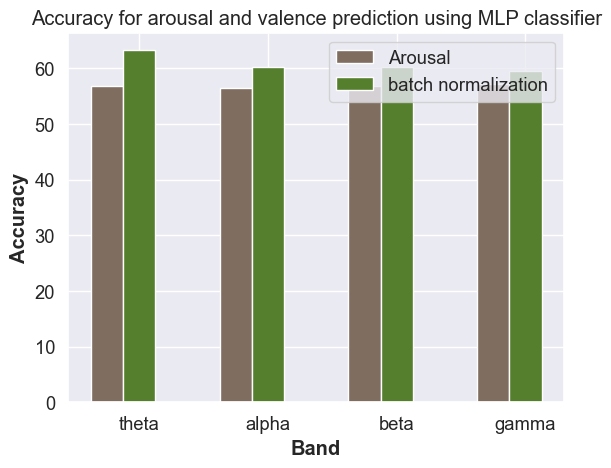

In [ ]:
# plot a side by side bar graph for arousal and valence accuracy for each band

# set width of bar
barWidth = 0.25

# set height of bar
bars1 = max_acc_a_mlp
bars2 = max_acc_a

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]


# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Arousal')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='batch normalization')

# Add xticks on the middle of the group bars
plt.xlabel('Band', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], band_names)
plt.ylabel('Accuracy', fontweight='bold')
plt.title("Accuracy for arousal and valence prediction using MLP classifier")
plt.legend()
plt.show()

In [ ]:
print(result)

[parietal    57.2
frontal     55.3
left        55.3
dtype: float64, left         56.82
right        56.44
occipital    56.06
dtype: float64]


In [ ]:
# for valence prediction accuracy
print_accuracy("valence","MLP")


Top 3 EEG regions with highest accuracy for valence prediction using MLP classifier
left         56.82
right        56.44
occipital    56.06
dtype: float64
Top 2 band with highest accuracy for valence prediction using MLP classifier
alpha    56.82
gamma    56.44
dtype: float64
EEG region with highest accuracy per each band 
theta         left
alpha         left
beta     occipital
gamma        right
dtype: object
EEG region with lowest accuracy per each band 
theta     central
alpha    parietal
beta     parietal
gamma        left
dtype: object
Band with highest accuracy per each EEG region 
frontal      gamma
central      gamma
parietal     theta
occipital    gamma
left         alpha
right        gamma
dtype: object
Band with lowest accuracy per each EEG region 
frontal       beta
central      theta
parietal      beta
occipital     beta
left         gamma
right        theta
dtype: object


,frontal,central,parietal,occipital,left,right
theta,51.89,51.52,54.17,54.92,55.68,54.17
alpha,51.14,52.65,47.35,55.30,56.82,54.55
beta,50.00,52.65,45.83,54.55,50.76,54.17
gamma,55.30,53.79,52.65,56.06,50.00,56.44


In [ ]:
# get f1 score
def get_f1(band,channel,label,clf):
    y_test,y_pred=run_model(band,channel,label,clf)

    return np.round(f1_score(y_test, y_pred,average='weighted')*100,2)


In [ ]:
def print_f1(label,clf):
    arr=[]
    for band in band_names:
        for channel in channel_names:
            arr.append(get_f1(band,channel,label,clf))
    arr=np.array(arr).reshape(4,6)
    df=pd.DataFrame(arr,index=band_names,columns=channel_names)
    print(df)

    print("Top 3 EEG regions with highest f1 score for "+label+" prediction using "+clf+" classifier")
    # print(df.unstack().sort_values(ascending=False)[:3])
    
    
    print(df.apply(lambda s: s.abs()).max().nlargest(3))
    print("==============================================================")

    print("Top 2 band with highest f1 score for "+label+" prediction using "+clf+" classifier")
    # print(df.mean(axis=1).sort_values(ascending=False)[:2])
    print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
    print("==============================================================")


    print("EEG region with highest f1 score per each band ")
    print(df.idxmax(axis=1))
    print("==============================================================")

    print("EEG region with lowest f1 score per each band ")
    print(df.idxmin(axis=1))
    print("==============================================================")

    print("Band with highest f1 score per each EEG region ")
    print(df.idxmax(axis=0))

    print("==============================================================")

    print("Band with lowest f1 score per each EEG region ")
    print(df.idxmin(axis=0))

In [ ]:
# for arousal prediction f1 score
print_f1("arousal","MLP")

       frontal  central  parietal  occipital   left  right
theta    50.24    45.79     53.83      43.21  44.39  44.14
alpha    52.41    46.42     53.89      42.31  42.55  44.76
beta     49.71    44.51     56.43      43.46  54.80  43.62
gamma    43.88    43.03     56.20      41.91  54.60  43.03
Top 3 EEG regions with highest f1 score for arousal prediction using MLP classifier
parietal    56.43
left        54.80
frontal     52.41
dtype: float64
Top 2 band with highest f1 score for arousal prediction using MLP classifier
beta     56.43
gamma    56.20
dtype: float64
EEG region with highest f1 score per each band 
theta    parietal
alpha    parietal
beta     parietal
gamma    parietal
dtype: object
EEG region with lowest f1 score per each band 
theta    occipital
alpha    occipital
beta     occipital
gamma    occipital
dtype: object
Band with highest f1 score per each EEG region 
frontal      alpha
central      alpha
parietal      beta
occipital     beta
left          beta
right        alp

In [ ]:
# for valence prediction f1 score
print_f1("valence","MLP")


       frontal  central  parietal  occipital   left  right
theta    42.10    43.15     53.84      42.36  49.26  41.39
alpha    39.73    44.29     47.40      43.11  49.00  41.02
beta     39.09    43.45     45.85      42.68  49.83  41.94
gamma    44.14    43.71     52.32      44.08  49.92  44.30
Top 3 EEG regions with highest f1 score for valence prediction using MLP classifier
parietal    53.84
left        49.92
right       44.30
dtype: float64
Top 2 band with highest f1 score for valence prediction using MLP classifier
theta    53.84
gamma    52.32
dtype: float64
EEG region with highest f1 score per each band 
theta    parietal
alpha        left
beta         left
gamma    parietal
dtype: object
EEG region with lowest f1 score per each band 
theta      right
alpha    frontal
beta     frontal
gamma    central
dtype: object
Band with highest f1 score per each EEG region 
frontal      gamma
central      alpha
parietal     theta
occipital    gamma
left         gamma
right        gamma
dtype

In [ ]:
# plot bar graph for accuracy comparison between MLP and BN
def plot_accuracy_comparison(label):
    arr=[]
    for band in band_names:
        for channel in channel_names:
            arr.append(get_acuracy(band,channel,label,"MLP"))
    arr=np.array(arr).reshape(4,6)
    df=pd.DataFrame(arr,index=band_names,columns=channel_names)
    df.plot.bar(figsize=(10,5))
    plt.title("Accuracy comparison between MLP and BN for "+label+" prediction")
    plt.ylabel("Accuracy")
    plt.xlabel("Band")
    plt.show()